In [13]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.decomposition as decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import pandas as pd

import mlgrad.af as af
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.boost.robanyboost as robanyboost
import mlgrad.boost.anyboost as anyboost
import mlgrad.inventory as inventory
import mlgrad.plots as plots

In [2]:
df = pd.read_csv("data/penguins.csv")
df.dropna(inplace=True)
df
bill_length = df["bill_length_mm"].values / 10
bill_depth = df["bill_depth_mm"].values / 10
flipper_length = df["flipper_length_mm"].values / 100
body_mass = df["body_mass_g"].values / 1000
sex = np.array([(1.0 if v == "MALE" else -1.0) for v in df["sex"]])

X = np.ascontiguousarray(np.c_[(bill_length, bill_depth, flipper_length, body_mass)])
Y = np.ascontiguousarray(sex)

N = len(Y)

In [3]:
# plt.figure(figsize=(12,9))
# for i in range(4):
#     for j in range(i,4):
#         plt.subplot(4,4,4*i+j+1)
#         if i == j:
#             plt.hist(X[:,i], rwidth=0.9)
#         else:
#             plt.scatter(X[:,j], X[:,i], c=Y)
# plt.show()

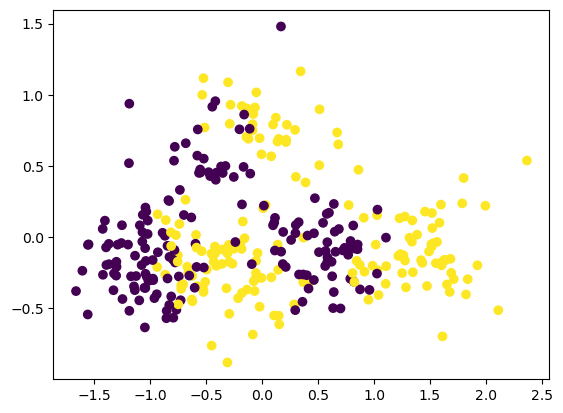

In [4]:
pca = decomposition.PCA(2)
U = pca.fit_transform(X)

plt.scatter(U[:,0], U[:,1], c=Y)
plt.show()

In [18]:
softhinge_func = funcs.SoftHinge_Exp(1.0)
def sigmoidal_factory(n):
    return models.SigmaNeuronModel(funcs.Sigmoidal(10.0), n)

In [19]:
shrink = 1.0
n_classifier = 50

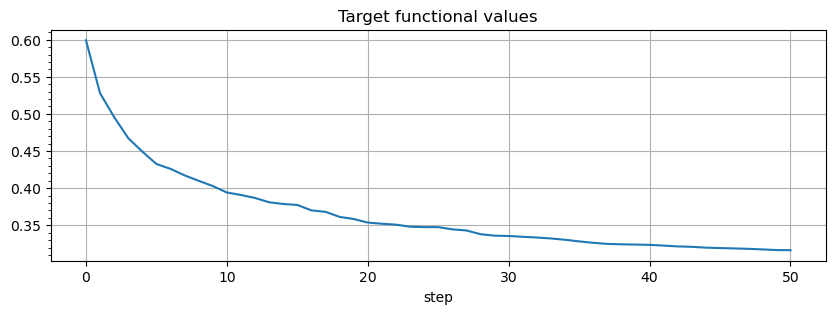

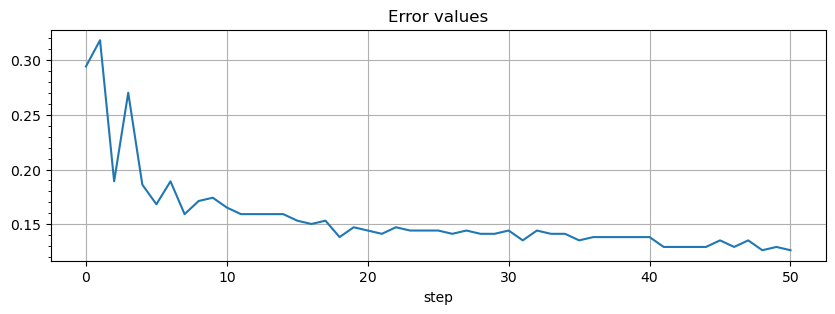

In [30]:
# cls = anyboost.AnyBoostClassification(
#     func=softhinge_func,
#     model_factory=sigmoidal_factory, 
#     shrink=shrink,
#     # min_weak_learn_score=0.01,
#     n_classifier=n_classifier)
# cls.fit(X, Y)

def anyboost(n_iter=100, shrink=1.0):
    cls = robanyboost.RobustAnyBoostClassification(
        aggfunc=af.averaging_function("AM"),
        func=softhinge_func, 
        model_factory=sigmoidal_factory, 
        shrink=shrink,
        # min_weak_learn_score=0.01,
        n_classifier=n_classifier)
    cls.fit(U, Y)
    return cls

cls = anyboost()

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Error values")
plt.plot(cls.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()


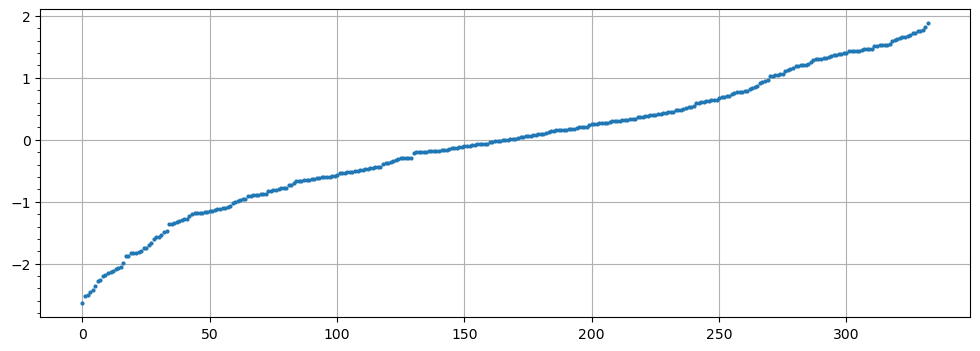

In [31]:
M = Y*cls.H.evaluate(U)
Z = inventory.modified_zscore(M)
# Z = inventory.zscore(M)

plt.figure(figsize=(12,4))
# plt.title("Classifier scores")
plt.plot(sorted(Z), marker='o', markersize=2, linewidth=0)
# plt.plot(sorted(Z), marker='o', markersize=2, linewidth=0)
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

In [32]:
# XX, YY = np.meshgrid(np.linspace(-2.0, 3.0, 400), np.linspace(-1.0, 2.0, 400))
# XY = np.c_[XX.ravel(), YY.ravel()]

# plt.figure(figsize=(6,5))
# ZZ = np.sign(cls.H.evaluate(XY))
# ZZ = ZZ.reshape(XX.shape)
# plt.scatter(U[:,0], U[:,1], c=Y, edgecolors='k')
# plt.contour(ZZ, extent=(-2.0, 3.0, -1.0, 2.0), levels=[0], colors=["darkblue"])
# plt.minorticks_on()
# plt.show()

0.9519519519519519


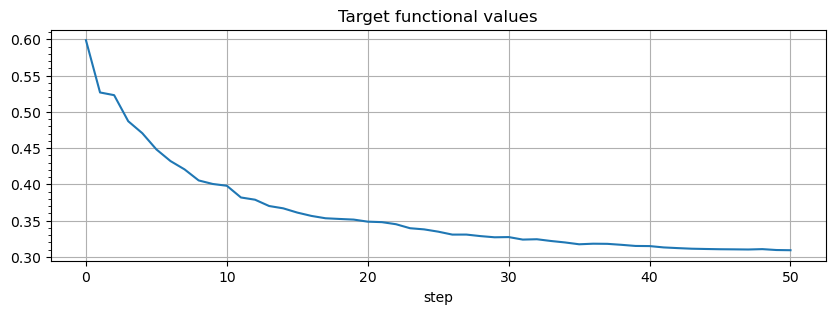

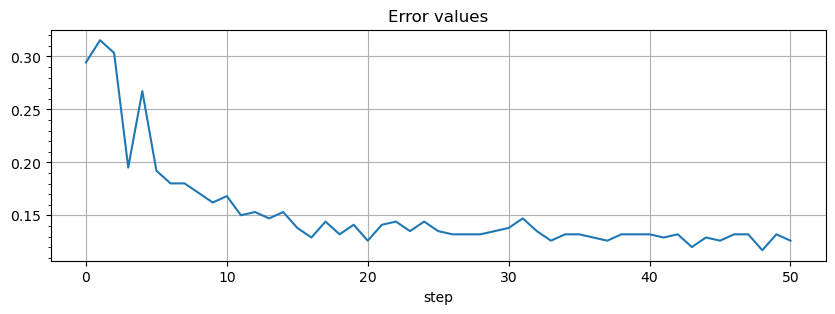

In [43]:
alpha = (abs(Z) <= 2.0).astype("i").sum() / N
if alpha == 1:
    alpha = 0.999
print(alpha)


def robust_anyboost(n_iter=100, shrink=1.0, alpha=0.99):
    cls2 = robanyboost.RobustAnyBoostClassification(
        aggfunc=af.averaging_function("WM", funcs.QuantileFunc(alpha, funcs.SoftAbs_Sqrt(0.001))),
        func=softhinge_func, 
        model_factory=sigmoidal_factory, 
        shrink=shrink,
        # min_weak_learn_score=0.01,
        n_classifier=n_classifier)
    cls2.fit(U, Y)
    return cls2

cls2 = robust_anyboost()

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls2.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Error values")
plt.plot(cls2.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()


In [24]:
# plt.figure(figsize=(12,3))
# plt.title("Weak classifier weights")
# plt.bar(range(len(cls.H.weights)), cls.H.weights)
# plt.minorticks_on()
# plt.show()

In [25]:
# plt.figure(figsize=(12,3))
# plt.title("Weak classifier weights")
# plt.bar(range(len(cls2.H.weights)), cls2.H.weights)
# plt.minorticks_on()
# plt.show()

In [26]:
accuracy = metrics.accuracy_score(np.sign(cls.H.evaluate(U)),Y)
accuracy2 = metrics.accuracy_score(np.sign(cls2.H.evaluate(U)),Y)
print(accuracy, accuracy2)

0.8738738738738738 0.8678678678678678


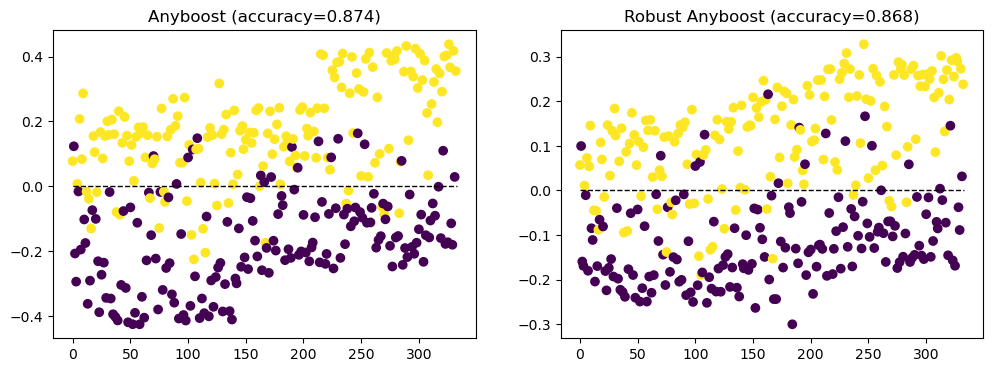

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title(f"Anyboost (accuracy={accuracy:.3f})")
plt.scatter(range(N), cls.H.evaluate(U), c=Y)
plt.hlines(0, 0, N, color='k', linestyles='--', linewidths=1.0)
# plt.ylim(-0.15,0.15)
plt.subplot(1,2,2)
plt.title(f"Robust Anyboost (accuracy={accuracy2:.3f})")
plt.scatter(range(N), cls2.H.evaluate(U), c=Y)
plt.hlines(0, 0, N, color='k', linestyles='--', linewidths=1.0)
# plt.ylim(-0.15,0.15)
plt.show()

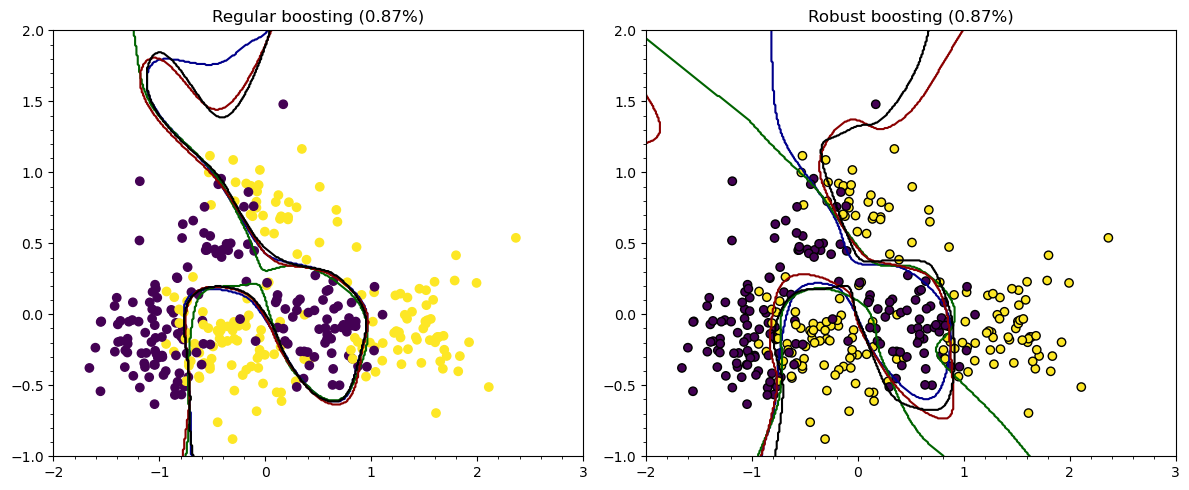

In [42]:
XX, YY = np.meshgrid(np.linspace(-2.0, 3.0, 400), np.linspace(-1.0, 2.0, 400))
XY = np.c_[XX.ravel(), YY.ravel()]
colors=["darkblue", "darkgreen", "darkred", "black"]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f"Regular boosting ({accuracy:.2f}%)")
plt.scatter(U[:,0], U[:,1], c=Y)
alphas = []
for i, k in enumerate([10,20,30,40]):
    cls = anyboost(n_iter=k)
    M = Y*cls.H.evaluate(U)
    Z = inventory.modified_zscore(M)
    alpha = (abs(Z) <= 2.0).astype("i").sum() / N
    alphas.append(alpha)
    ZZ = np.sign(cls.H.evaluate(XY))
    ZZ = ZZ.reshape(XX.shape)
    plt.contour(ZZ, extent=(-2.0, 3.0, -1.0,2.0), levels=[0], colors=colors[i])
plt.minorticks_on()
# plt.legend()
plt.subplot(1,2,2)
plt.title(f"Robust boosting ({accuracy2:.2f}%)")
plt.scatter(U[:,0], U[:,1], c=Y, edgecolors='k')
for i, k in enumerate([10,20,30,40]):
    cls2 = robust_anyboost(n_iter=k, alpha=alphas[i])
    ZZ2 = np.sign(cls2.H.evaluate(XY))
    ZZ2 = ZZ2.reshape(XX.shape)
    plt.contour(ZZ2, extent=(-2.0, 3.0, -1.0,2.0), levels=[0], colors=colors[i])
plt.minorticks_on()
# plt.legend()
plt.savefig("fig/robanyboost_1.eps")
plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


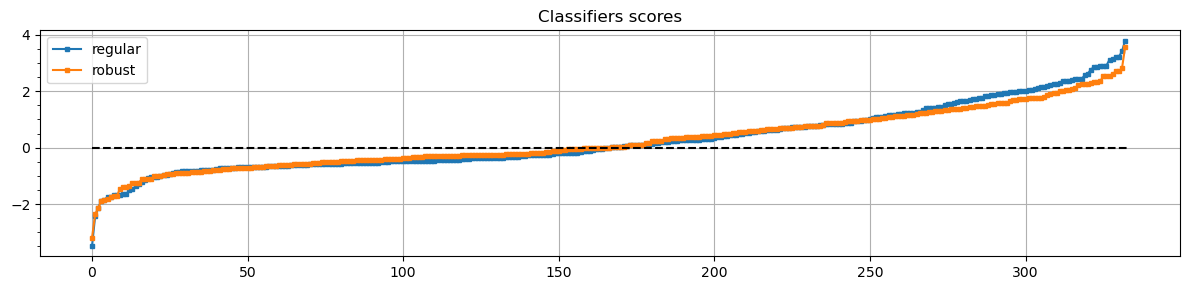

In [103]:
M2 = Y*cls2.H.evaluate(U)
Z2 = inventory.modified_zscore(M2)

plt.figure(figsize=(12,3))
plt.title("Classifiers scores")
plt.plot(sorted(Z), marker='s', markersize=3, label='regular')
plt.plot(sorted(Z2), marker='s', markersize=3, label='robust')
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.legend()
plt.hlines(0, 0, N, colors='k', linestyles='--')
plt.savefig("fig/robanyboost_2.eps")
plt.tight_layout()
plt.show()

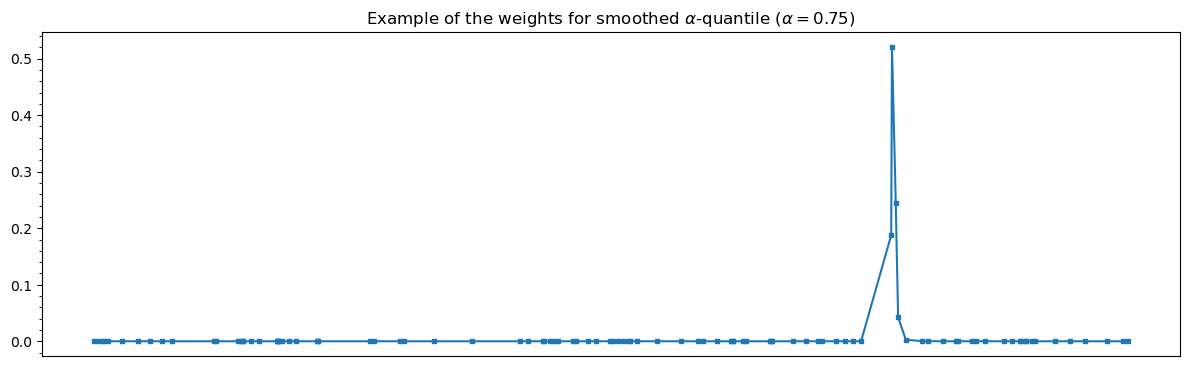

In [26]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("M", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed $\alpha$-quantile ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/quantile_weights.eps")
plt.tight_layout()
plt.minorticks_on()
plt.xticks([])
plt.show()

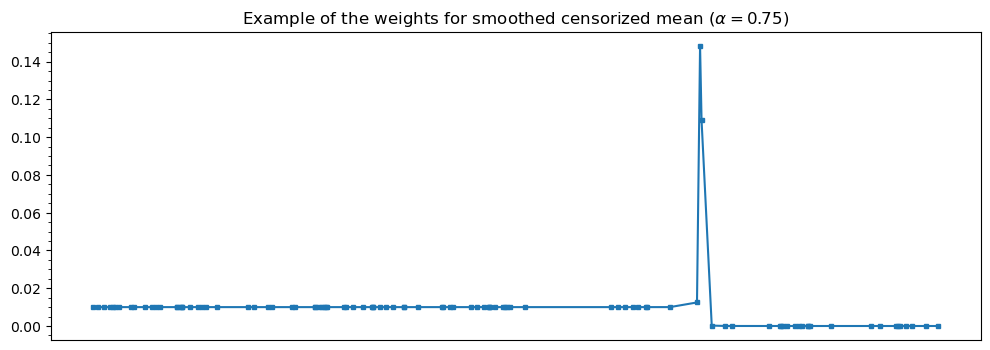

In [27]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("WM", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed censorized mean ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/cp_weights.eps")
plt.minorticks_on()
plt.xticks([])
plt.show()

In [1]:
import scipy.optimize as opt